#Logistic Regression with L2 regularization

The goal of this assignment is to implement your own logistic regression classifier with L2 regularization. You will do the following:

Extract features from Amazon product reviews.
Convert an dataframe into a NumPy array.
Write a function to compute the derivative of log likelihood function with an L2 penalty with respect to a single coefficient.
Implement gradient ascent with an L2 penalty.
Empirically explore how the L2 penalty can ameliorate overfitting.

In [1]:
import pandas as pd
import numpy as np

In [2]:
products = pd.read_csv('/Users/April/Downloads/amazon_baby_subset.csv')

In [3]:
import json
with open('/Users/April/Desktop/datasci_course_materials-master/assignment1/important words.json', 'r') as f: # Reads the list of most frequent words
    important_words = json.load(f)
important_words = [str(s) for s in important_words]

In [4]:
products = products.fillna({'review':''})  # fill in N/A's in the review column

In [5]:
def remove_punctuation(text):
    import string
    return text.translate(None, string.punctuation) 

In [6]:
products['review_clean'] = products['review'].apply(remove_punctuation)

In [7]:
for word in important_words:
    products[word] = products['review_clean'].apply(lambda s : s.split().count(word))

In [8]:
products['contains_perfect'] = products['perfect'].apply(lambda pf: 1 if pf >=1 else 0)

In [9]:
sum(products['contains_perfect'] == 1)

2955

In [10]:
with open('/Users/April/Desktop/datasci_course_materials-master/assignment1/train index.json', 'r') as f1:
    train_index = json.load(f1)

In [11]:
with open('/Users/April/Desktop/datasci_course_materials-master/assignment1/validation index.json', 'r') as f2:
    validation_index = json.load(f2)

In [12]:
train_data = products.iloc[train_index]

In [13]:
validation_data = products.iloc[validation_index]

#Convert data frame to multi-dimensional array

In [14]:
def get_numpy_data(dataframe, features, label):
    dataframe['constant'] = 1
    features = ['constant'] + features
    features_frame = dataframe[features]
    feature_matrix = features_frame.as_matrix()
    label_sarray = dataframe[label]
    label_array = label_sarray.as_matrix()
    return(feature_matrix, label_array) #Why do we need transpose it to matrix?

In [15]:
feature_matrix_train, sentiment_train = get_numpy_data(train_data, important_words, 'sentiment')
feature_matrix_valid, sentiment_valid = get_numpy_data(validation_data, important_words, 'sentiment') 

/Users/April/anaconda/envs/dato-env/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app


# Building on logistic regression with no L2 penalty assignment

In [16]:
def predict_probability(feature_matrix, coefficients):
    # Take dot product of feature_matrix and coefficients  
    # YOUR CODE HERE
    score = np.dot(feature_matrix, coefficients)
    
    # Compute P(y_i = +1 | x_i, w) using the link function
    # YOUR CODE HERE
    predictions = 1/(1+np.exp(-score))
    
    # return predictions
    return predictions

#Adding L2 penalty

 Let us now work on extending logistic regression with an L2 penalty. As discussed in the lectures, the L2 regularization is particularly useful in preventing overfitting. In this assignment, we will explore L2 regularization in detail.

Recall from lecture and the previous assignment that for logistic regression without an L2 penalty, the derivative of the log-likelihood function is:



Write a function that computes the derivative of log likelihood with respect to a single coefficient w_j. Unlike its counterpart in the last assignment, the function accepts five parameters:

The function should do the following:

Take the five parameters as above.
Compute the dot product of errors and feature and save the result to derivative.
If feature_is_constant is False, subtract the L2 penalty term from derivative. Otherwise, do nothing.
Return derivative.

In [17]:
def feature_derivative_with_L2(errors, feature, coefficient, l2_penalty, feature_is_constant): 
   
    # Compute the dot product of errors and feature
    ## YOUR CODE HERE
    derivative = np.dot(errors, feature) 

    # add L2 penalty term for any feature that isn't the intercept.
    if not feature_is_constant: 
        ## YOUR CODE HERE
        derivative = np.dot(errors, feature) - 2*l2_penalty*coefficient
    
    return derivative

To verify the correctness of the gradient descent algorithm, we write a function for computing log likelihood (which we recall from the last assignment was a topic detailed in an advanced optional video, and used here for its numerical stability), which is given by the formula

In [18]:
def compute_log_likelihood_with_L2(feature_matrix, sentiment, coefficients, l2_penalty):
    indicator = (sentiment==+1)
    scores = np.dot(feature_matrix, coefficients)
    
    lp = np.sum((indicator-1)*scores - np.log(1. + np.exp(-scores))) - l2_penalty*np.sum(coefficients[1:]**2)
    
    return lp

Quiz question: Does the term with L2 regularization increase or decrease ℓℓ(w)?

decrease because l2_penalty*np.sum(coefficients[1:]**2) > 0

he logistic regression function looks almost like the one in the last assignment, with a minor modification to account for the L2 penalty.

Write a function logistic_regression_with_L2 to fit a logistic regression model under L2 regularization.

The function accepts the following parameters:

feature_matrix: 2D array of features
sentiment: 1D array of class labels
initial_coefficients: 1D array containing initial values of coefficients
step_size: a parameter controlling the size of the gradient steps
l2_penalty: the L2 penalty constant λ
max_iter: number of iterations to run gradient ascent
The function returns the last set of coefficients after performing gradient ascent.

The function carries out the following steps:

Initialize vector coefficients to initial_coefficients.
Predict the class probability P(y_i = +1 | x_i,w) using your predict_probability function and save it to variable predictions.
Compute indicator value for (y_i = +1) by comparing sentiment against +1. Save it to variable indicator.
Compute the errors as difference between indicator and predictions. Save the errors to variable errors.
For each j-th coefficient, compute the per-coefficient derivative by calling feature_derivative_L2 with the j-th column of feature_matrix. Don't forget to supply the L2 penalty. Then increment the j-th coefficient by (step_size*derivative).
Once in a while, insert code to print out the log likelihood.
Repeat steps 2-6 for max_iter times.


In [19]:
def logistic_regression_with_L2(feature_matrix, sentiment, initial_coefficients, 
  step_size, l2_penalty, max_iter):
    coefficients = np.array(initial_coefficients) # make sure it's a numpy array
    for itr in xrange(max_iter):
        # Predict P(y_i = +1|x_i,w) using your predict_probability() function
        ## YOUR CODE HERE
        predictions = predict_probability(feature_matrix, coefficients)
        
        # Compute indicator value for (y_i = +1)
        indicator = (sentiment==+1)
        
        # Compute the errors as indicator - predictions
        errors = indicator - predictions
        for j in xrange(len(coefficients)): # loop over each coefficient
            is_intercept = (j == 0)
            # Recall that feature_matrix[:,j] is the feature column associated with coefficients[j].
            # Compute the derivative for coefficients[j]. Save it in a variable called derivative
            ## YOUR CODE HERE
            derivative = feature_derivative_with_L2(
                errors, feature_matrix[:,j], coefficients[j], l2_penalty, is_intercept)
            
            # add the step size times the derivative to the current coefficient
            ## YOUR CODE HERE
            coefficients[j] = step_size * derivative
        
        # Checking whether log likelihood is increasing
        if itr <= 15 or (itr <= 100 and itr % 10 == 0) or (itr <= 1000 and itr % 100 == 0) \
        or (itr <= 10000 and itr % 1000 == 0) or itr % 10000 == 0:
            lp = compute_log_likelihood_with_L2(feature_matrix, sentiment, coefficients, l2_penalty)
            print 'iteration %*d: log likelihood of observed labels = %.8f' % \
                (int(np.ceil(np.log10(max_iter))), itr, lp)
    return coefficients

#Explore effects of L2 regularization

Now that we have written up all the pieces needed for an L2 solver with logistic regression, let's explore the benefits of using L2 regularization while analyzing sentiment for product reviews. As iterations pass, the log likelihood should increase.

Let us train models with increasing amounts of regularization, starting with no L2 penalty, which is equivalent to our previous logistic regression implementation. Train 6 models with L2 penalty values 0, 4, 10, 1e2, 1e3, and 1e5. Use the following values for the other parameters:

feature_matrix = feature_matrix_train extracted in #7
sentiment = sentiment_train extracted in #7
initial_coefficients = a 194-dimensional vector filled with zeros
step_size = 5e-6
max_iter = 501
Save the 6 sets of coefficients as coefficients_0_penalty, coefficients_4_penalty, coefficients_10_penalty, coefficients_1e2_penalty, coefficients_1e3_penalty, and coefficients_1e5_penalty respectively.

In [20]:
L2_penalty_list = [0, 4, 10, 1e2, 1e3, 1e5]

In [21]:
feature_matrix = feature_matrix_train
sentiment = sentiment_train 
initial_coefficients = np.zeros(194)
step_size = 5e-6
max_iter = 501

In [22]:
coefficients_list = [logistic_regression_with_L2(feature_matrix, sentiment, initial_coefficients, 
  step_size, l2_penalty, max_iter) for l2_penalty in L2_penalty_list]

iteration   0: log likelihood of observed labels = -29179.39138303
iteration   1: log likelihood of observed labels = -29183.07101158
iteration   2: log likelihood of observed labels = -29182.87850538
iteration   3: log likelihood of observed labels = -29182.90844738
iteration   4: log likelihood of observed labels = -29182.90188394
iteration   5: log likelihood of observed labels = -29182.90339394
iteration   6: log likelihood of observed labels = -29182.90304383
iteration   7: log likelihood of observed labels = -29182.90312511
iteration   8: log likelihood of observed labels = -29182.90310623
iteration   9: log likelihood of observed labels = -29182.90311061
iteration  10: log likelihood of observed labels = -29182.90310960
iteration  11: log likelihood of observed labels = -29182.90310983
iteration  12: log likelihood of observed labels = -29182.90310978
iteration  13: log likelihood of observed labels = -29182.90310979
iteration  14: log likelihood of observed labels = -29182.9031

In [23]:
coefficients_list[2]

array([  5.26218044e-04,   1.94927276e-03,  -1.64183528e-03,
         9.05744405e-03,   9.11075879e-03,   5.51855484e-04,
        -7.96348801e-03,  -7.01144157e-04,   8.87843938e-03,
         6.02880307e-03,   7.10408055e-04,   2.83324647e-03,
         4.02453428e-03,  -4.46251528e-03,   1.99321446e-03,
        -2.55964933e-04,   1.62609911e-03,  -2.71417899e-03,
        -1.89939300e-03,  -6.10049409e-03,   3.33719121e-04,
         2.46130817e-03,  -7.63639479e-04,   6.19003193e-03,
         1.37874615e-03,  -2.59940964e-05,  -8.87149256e-05,
         1.81610581e-03,   1.03213972e-03,  -3.91408067e-03,
         8.79186956e-05,   1.88546698e-03,  -1.94173840e-03,
        -4.29341996e-03,   4.01926224e-03,   2.45245021e-03,
         3.53484058e-04,  -1.63170875e-03,  -9.14470443e-05,
        -1.54234210e-03,  -7.65713157e-04,   1.06534141e-03,
         5.10244008e-04,   3.34780389e-04,  -3.56814277e-04,
         1.11215457e-03,  -8.09968032e-05,  -2.90423802e-03,
         2.36275138e-03,

In [24]:
coefficients_name = ['coefficients_0_penalty', 'coefficients_4_penalty', 'coefficients_10_penalty', 'coefficients_1e2_penalty', 
                     'coefficients_1e3_penalty', 'coefficients_1e5_penalty' ]

In [25]:
coefficients_dict = dict(zip(coefficients_name, coefficients_list))

In [26]:
coefficients_dict

{'coefficients_0_penalty': array([  5.26235043e-04,   1.94947479e-03,  -1.64197820e-03,
          9.05834108e-03,   9.11165871e-03,   5.51918608e-04,
         -7.96424741e-03,  -7.01202770e-04,   8.87931807e-03,
          6.02940198e-03,   7.10478734e-04,   2.83352951e-03,
          4.02493663e-03,  -4.46294134e-03,   1.99341540e-03,
         -2.55983813e-04,   1.62626403e-03,  -2.71443539e-03,
         -1.89957480e-03,  -6.10108191e-03,   3.33757847e-04,
          2.46155464e-03,  -7.63708515e-04,   6.19064587e-03,
          1.37888065e-03,  -2.59915516e-05,  -8.87193142e-05,
          1.81628560e-03,   1.03224705e-03,  -3.91445818e-03,
          8.79329071e-05,   1.88565785e-03,  -1.94192278e-03,
         -4.29383634e-03,   4.01966219e-03,   2.45269558e-03,
          3.53521569e-04,  -1.63186449e-03,  -9.14513400e-05,
         -1.54248934e-03,  -7.65786397e-04,   1.06544986e-03,
          5.10296788e-04,   3.34816733e-04,  -3.56848284e-04,
          1.11226765e-03,  -8.10006223e-05, 

#Compare coefficients

We now compare the coefficients for each of the models that were trained above. Create a table of features and learned coefficients associated with each of the different L2 penalty values.

Using the coefficients trained with L2 penalty 0, find the 5 most positive words (with largest positive coefficients). Save them to positive_words. Similarly, find the 5 most negative words (with largest negative coefficients) and save them to negative_words.

Quiz Question. Which of the following is not listed in either positive_words or negative_words?

In [27]:
coefficients_0_penalty = list(coefficients_dict['coefficients_0_penalty'][1:]) # exclude intercept
word_coefficient_0_penalty_tuples = [(word, coefficient) for word, coefficient in zip(important_words, coefficients_0_penalty)]
word_coefficient_0_penalty_tuples = sorted(word_coefficient_0_penalty_tuples, key=lambda x:x[1], reverse=True)

In [28]:
word_coefficient_0_penalty_tuples[:5]

[('love', 0.009111658707277601),
 ('great', 0.0090583410787265749),
 ('easy', 0.0088793180712080141),
 ('loves', 0.006190645867205467),
 ('little', 0.0060294019786029654)]

In [29]:
word_coefficient_0_penalty_tuples[-5:]

[('get', -0.004462941344722764),
 ('work', -0.00472433795893599),
 ('money', -0.0054439850449472943),
 ('product', -0.0061010819064690608),
 ('would', -0.0079642474141327878)]

Let us observe the effect of increasing L2 penalty on the 10 words just selected. Make a plot of the coefficients for the 10 words over the different values of L2 penalty.

Hints:

First, extract rows corresponding to positive_words. Do the same for negative_words.
Then plot each of the extracted rows. The x axis should be L2 penalty and the y axis should be the coefficient value.
Use log scale for the x axis, as the L2 penalty values are exponentially spaced.

create a dataframe for important words and coefficients

In [30]:
new_dict = dict(coefficients_dict)

In [31]:
new_dict.update({'word': ['(intercept)'] + important_words})

In [32]:
word_penality_coef = pd.DataFrame(new_dict)

In [33]:
word_penality_coef.head()

,coefficients_0_penalty,coefficients_10_penalty,coefficients_1e2_penalty,coefficients_1e3_penalty,coefficients_1e5_penalty,coefficients_4_penalty,word
0,0.000526,0.000526,0.000526,0.000525,-0.104351,0.000526,(intercept)
1,0.001949,0.001949,0.001947,0.001929,-17.344002,0.001949,baby
2,-0.001642,-0.001642,-0.001641,-0.001628,-19.459873,-0.001642,one
3,0.009058,0.009057,0.009049,0.008970,-10.768619,0.009058,great
4,0.009112,0.009111,0.009103,0.009023,-6.845966,0.009111,love


In [34]:
newcolumns = word_penality_coef.columns.tolist()

In [35]:
newcolumns_2 = newcolumns[-1:] + newcolumns[:-1]

In [36]:
word_penality_coef = word_penality_coef[newcolumns_2]
word_penality_coef

,word,coefficients_0_penalty,coefficients_10_penalty,coefficients_1e2_penalty,coefficients_1e3_penalty,coefficients_1e5_penalty,coefficients_4_penalty
0,(intercept),0.000526,0.000526,0.000526,0.000525,-0.104351,0.000526
1,baby,0.001949,0.001949,0.001947,0.001929,-17.344002,0.001949
2,one,-0.001642,-0.001642,-0.001641,-0.001628,-19.459873,-0.001642
3,great,0.009058,0.009057,0.009049,0.008970,-10.768619,0.009058
4,love,0.009112,0.009111,0.009103,0.009023,-6.845966,0.009111
5,use,0.000552,0.000552,0.000551,0.000546,-13.821567,0.000552
6,would,-0.007964,-0.007963,-0.007957,-0.007889,-17.091981,-0.007964
7,like,-0.000701,-0.000701,-0.000701,-0.000695,-13.099545,-0.000701
8,easy,0.008879,0.008878,0.008871,0.008792,-7.242241,0.008879
9,little,0.006029,0.006029,0.006023,0.005970,-9.038187,0.006029


In [37]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 6

def make_coefficient_plot(table, positive_words, negative_words, l2_penalty_list):
    cmap_positive = plt.get_cmap('Reds')
    cmap_negative = plt.get_cmap('Blues')
    
    xx = l2_penalty_list
    plt.plot(xx, [0.]*len(xx), '--', lw=1, color='k')
    
    table_positive_words = table[table['word'].isin(positive_words)]
    table_negative_words = table[table['word'].isin(negative_words)]
    del table_positive_words['word']
    del table_negative_words['word']
    
    for i in xrange(len(positive_words)):
        color = cmap_positive(0.8*((i+1)/(len(positive_words)*1.2)+0.15))
        plt.plot(xx, table_positive_words[i:i+1].as_matrix().flatten(),
                 '-', label=positive_words[i], linewidth=4.0, color=color)
        
    for i in xrange(len(negative_words)):
        color = cmap_negative(0.8*((i+1)/(len(negative_words)*1.2)+0.15))
        plt.plot(xx, table_negative_words[i:i+1].as_matrix().flatten(),
                 '-', label=negative_words[i], linewidth=4.0, color=color)
        
    plt.legend(loc='best', ncol=3, prop={'size':16}, columnspacing=0.5)
    plt.axis([1, 1e5, -1, 2])
    plt.title('Coefficient path')
    plt.xlabel('L2 penalty ($\lambda$)')
    plt.ylabel('Coefficient value')
    plt.xscale('log')
    plt.rcParams.update({'font.size': 18})
    plt.tight_layout()




In [38]:
positive_words = [pw for pw, coef in word_coefficient_0_penalty_tuples[:5]]

In [39]:
negative_words = [nw for nw, coeff in word_coefficient_0_penalty_tuples[-5:]]

In [40]:
negative_words

['get', 'work', 'money', 'product', 'would']

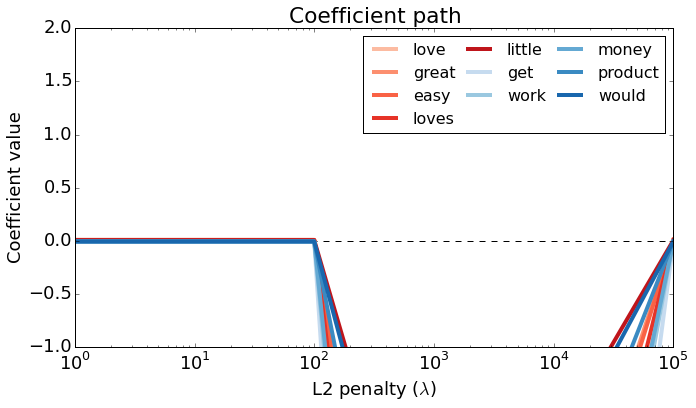

In [41]:
make_coefficient_plot(word_penality_coef, positive_words, negative_words, l2_penalty_list=[0, 4, 10, 1e2, 1e3, 1e5])

#Measuring accuracy

Quiz question: Which model (L2 = 0, 4, 10, 100, 1e3, 1e5) has the highest accuracy on the training data?
Quiz question: Which model (L2 = 0, 4, 10, 100, 1e3, 1e5) has the highest accuracy on the validation data?
Quiz question: Does the highest accuracy on the training data imply that the model is the best one?

In [64]:
def model_accuaracy(feature_matrix, sentiment, coefficients):
    scores_new = np.dot(feature_matrix, coefficients)
    predictions = np.array([+1 if s > 0 else -1 for s in scores_new])
    num_correct = sum(predictions == sentiment)
    accuracy = float(num_correct) / len(feature_matrix)   
    return accuracy

In [65]:
train_accuracy = {}
train_accuracy[0]   = model_accuaracy(feature_matrix_train, sentiment_train, coefficients_dict['coefficients_0_penalty'])
train_accuracy[4]   = model_accuaracy(feature_matrix_train, sentiment_train, coefficients_dict['coefficients_4_penalty'])
train_accuracy[10]  = model_accuaracy(feature_matrix_train, sentiment_train, coefficients_dict['coefficients_10_penalty'])
train_accuracy[1e2] = model_accuaracy(feature_matrix_train, sentiment_train, coefficients_dict['coefficients_1e2_penalty'])
train_accuracy[1e3] = model_accuaracy(feature_matrix_train, sentiment_train, coefficients_dict['coefficients_1e3_penalty'])
train_accuracy[1e5] = model_accuaracy(feature_matrix_train, sentiment_train, coefficients_dict['coefficients_1e5_penalty'])

validation_accuracy = {}
validation_accuracy[0]   = model_accuaracy(feature_matrix_valid, sentiment_valid, coefficients_dict['coefficients_0_penalty'])
validation_accuracy[4]   = model_accuaracy(feature_matrix_valid, sentiment_valid, coefficients_dict['coefficients_4_penalty'])
validation_accuracy[10]  = model_accuaracy(feature_matrix_valid, sentiment_valid, coefficients_dict['coefficients_10_penalty'])
validation_accuracy[1e2] = model_accuaracy(feature_matrix_valid, sentiment_valid, coefficients_dict['coefficients_1e2_penalty'])
validation_accuracy[1e3] = model_accuaracy(feature_matrix_valid, sentiment_valid, coefficients_dict['coefficients_1e3_penalty'])
validation_accuracy[1e5] = model_accuaracy(feature_matrix_valid, sentiment_valid, coefficients_dict['coefficients_1e5_penalty'])

In [66]:
# Build a simple report
for key in sorted(validation_accuracy.keys()):
    print "L2 penalty = %g" % key
    print "train accuracy = %s, validation_accuracy = %s" % (train_accuracy[key], validation_accuracy[key])
    print "--------------------------------------------------------------------------------"

L2 penalty = 0
train accuracy = 0.747574419867, validation_accuracy = 0.746522266828
--------------------------------------------------------------------------------
L2 penalty = 4
train accuracy = 0.747574419867, validation_accuracy = 0.746522266828
--------------------------------------------------------------------------------
L2 penalty = 10
train accuracy = 0.747574419867, validation_accuracy = 0.746522266828
--------------------------------------------------------------------------------
L2 penalty = 100
train accuracy = 0.747574419867, validation_accuracy = 0.746522266828
--------------------------------------------------------------------------------
L2 penalty = 1000
train accuracy = 0.747503600009, validation_accuracy = 0.746615628793
--------------------------------------------------------------------------------
L2 penalty = 100000
train accuracy = 0.498430159817, validation_accuracy = 0.502194006162
--------------------------------------------------------------------------